In [1]:
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, Input, Activation, Reshape, Flatten
from keras.callbacks import TensorBoard
from keras.utils import to_categorical, plot_model
from keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
from ImageUtils import ImageUtils
import pickle
import keras.backend as K
from keras import regularizers

D:\sf\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''常量'''
sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimages'
targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimagesResize_1_2'
root = 'D:/jupyter/car-management/recognitionalgorithm/dataset'
Xfilename = 'licenseplateL_1_2.npy'
Yfilename = 'label_1_2.npy'
filename = '字典.xlsx'

'''测试集'''
t_sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/general_test'
t_targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/testim_1_2'
t_Xfilename = 't_licenseplateL.npy'
t_Yfilename = 't_label.npy'

'''验证集'''
v_sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/validset_1_2'
v_targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/validresizeim_1_2'

In [3]:
def getlistargmax(inputs):
    outputs = []
    for i in range(len(inputs)):
        outputs.append(np.argmax(inputs[i]))
    return outputs

In [4]:
'''数据处理工具类'''
utils = ImageUtils()

In [18]:
'''resize image'''
utils.resizeAndSaveImage(sourceFolder, targetFolder, shape = (320, 320))
utils.resizeAndSaveImage(t_sourceFolder, t_targetFolder, shape = (320, 320))

In [5]:
'''处理数据'''
X = utils.readXData(targetFolder, shape = (320, 320, 3))
Y = utils.readYData(root, targetFolder, filename)
utils.save(root, Xfilename, Yfilename, X, Y)

t_X = utils.readXData(t_targetFolder, shape = (320, 320, 3))
t_Y = utils.readYData(root, t_targetFolder, filename)
utils.save(root, t_Xfilename, t_Yfilename, t_X, t_Y)

In [6]:
X_test_orig, Y_test = utils.load(root, t_Xfilename, t_Yfilename)
X_test = (X_test_orig / 255).astype('float32')

In [7]:
'''加载处理的数据'''
X_train_orig, Y_train_orig = utils.load(root, Xfilename, Yfilename)
X_train = (X_train_orig / 255).astype('float32')

Y_train = to_categorical(np.transpose(Y_train_orig), 66)

In [8]:
Y_label = []
for i in range(len(Y_train)):
    Y_label.append(Y_train[i])

x's shape: (1222, 320, 320, 3)
y's shape: (7, 1222, 66)
云MWG626
[18 53 62 47 37 33 37]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


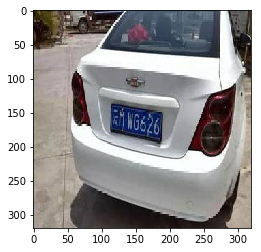

In [9]:
'''查看数据'''
print("x's shape: " + str(X_train.shape))
print("y's shape: " + str(Y_train.shape))
plt.imshow(X_train[23])
print(utils.getLabel(root, filename, Y_train_orig[23]))
# print(utils.getLabel(root, filename, np.argmax(Y_train[11], axis = -1)))
print(Y_train_orig[23])
print(Y_label[0][23])

In [18]:
'''define vgg model'''
def vgg_model(input_shape, classesandoutnums):
    inputs = Input(shape = input_shape)
    X = Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), strides = 2)(inputs)
    X = Conv2D(32, (3, 3), activation='relu', strides = 3)(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    outnum, classes = classesandoutnums
    outputs = []
    for i in range(outnum):
        output = Dense(classes, kernel_initializer = 'glorot_normal', activation='softmax')(X)
        outputs.append(output)
    
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [10]:
def inception_block(X, name, filters, strides):
    '''first layers'''
    f_skip_1, f_1_1, f_1_2, f_2_1, f_2_2, f_2_3 = filters 
    base_name = 'inception' + str(name)
    
    conv_1_1 = Conv2D(f_1_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    conv_1_2 = Conv2D(f_2_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_2', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    pool_1_1 = MaxPooling2D((3, 3), strides = strides, padding = 'same', name = base_name + '_p_1_1')(X)
    
    conv_skip_1 = Conv2D(f_skip_1, (1, 1), strides = 2 * strides, padding = 'same', name = base_name + '_skip_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    
    conv_2_1 = Conv2D(f_2_1, (3, 3), padding = 'same', strides = strides, name = base_name + '_c_2_1', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_1)
    conv_2_2 = Conv2D(f_2_2, (5, 5), padding = 'same', strides = strides, name = base_name + '_c_2_2', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_2)
    conv_2_3 = Conv2D(f_2_3, (1, 1), padding = 'same', strides =  strides, name = base_name + '_c_2_3', activation = 'relu', kernel_initializer = 'truncated_normal')(pool_1_1)
    
    # 合并
    inception = Concatenate(axis = -1, name = base_name + '_ct_1_1')([conv_skip_1, conv_2_1, conv_2_2, conv_2_3])
    
    bn = BatchNormalization(name = base_name + '_bn_1')(inception)
    
    return bn

In [11]:
'''测试'''
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

inputs_x = np.random.rand(1, 320, 320, 3)
inputs = Input(shape = (320, 320, 3))
outputs = inception_block(inputs, 1, (6, 6, 6, 6, 6, 6), strides = 2)
inception_model = Model(inputs = inputs, outputs = outputs)
# inception_model.summary()

plot_model(inception_model, to_file = 'inception_model.png', show_shapes = True, show_layer_names = True)
# y = inception_model.predict_on_batch(inputs_x)
y = inception_model.predict(inputs_x, batch_size = 1)
# print(y.shape)

In [12]:
def identify_block(X, filters, name, strides):
    conv_name = 'identify_conv' + str(name)
    bn_name = 'identify_bn_name' + str(name)
    activation_name = 'identify_activation_name' + str(name)
    add_name = 'identify_add' + str(name)
    skip_name = 'identify_skip' + str(name)
    
    f_1_1, f_1_2, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (3, 3), strides = strides, padding = 'same', name = conv_name + '_1_1', kernel_initializer = 'truncated_normal')(X)
    bn_1_1 = BatchNormalization(name = bn_name + '_1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '_1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '_2_1', kernel_initializer = 'truncated_normal')(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '_2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '_2_1')(bn_2_1)
    
    '''skip unit'''
    skip_strides = 2 * strides
    if strides == 1:
        skip_strides = 1
        
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, padding = 'same', name = skip_name + '_1_1', kernel_initializer = 'truncated_normal')(X)
    
    identify = Add(name = add_name + '_1_1')([activation_2_1, conv_skip_1_1])
    
    return identify

In [16]:
inputs_x = np.random.rand(1, 320, 320, 1)
inputs = Input(shape = (320, 320, 1))
outputs = identify_block(inputs, filters = (3, 3, 3), name = '1', strides = 2)
identify_model = Model(inputs = inputs, outputs = outputs)
identify_y = identify_model.predict(inputs_x)
print(identify_y.shape)
identify_model.summary()

(1, 80, 80, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
identify_conv1_1_1 (Conv2D)     (None, 160, 160, 3)  30          input_1[0][0]                    
__________________________________________________________________________________________________
identify_bn_name1_1_1 (BatchNor (None, 160, 160, 3)  12          identify_conv1_1_1[0][0]         
__________________________________________________________________________________________________
identify_activation_name1_1_1 ( (None, 160, 160, 3)  0           identify_bn_name1_1_1[0][0]      
______________________________________________________________________________________________

In [13]:
'''build convlution block'''
def bottleneck_block(X, filters, name, strides):
    conv_name = 'bk_conv' + str(name)
    bn_name = 'bk_bn' + str(name)
    activation_name = 'bk_an' + str(name)
    add_name = 'bk_add' + str(name)
    skip_name = 'bk_sk' + str(name)
    
    f_1_1, f_1_2, f_1_3, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (1, 1), strides = strides, padding = 'same', name = conv_name + '1_1', kernel_initializer = 'truncated_normal')(X)
    bn_1_1 = BatchNormalization(name = bn_name + '1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '2_1', kernel_initializer = 'truncated_normal')(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '2_1')(bn_2_1)
    
    '''skip unit'''
    conv_3_1 = Conv2D(f_1_3, (1, 1), strides = strides, padding = 'same', name = conv_name + '3_1', kernel_initializer = 'truncated_normal')(activation_2_1)
    bn_3_1 = BatchNormalization(name = bn_name + '3_1')(conv_3_1)
    activation_3_1 = Activation('relu', name = activation_name + '3_1')(bn_3_1)
    
    '''skip unit'''
    skip_strides = int(pow(strides, 3))
    if strides == 1:
        skip_strides = 1
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, name = skip_name + 'c_1_1', padding = 'same', kernel_initializer = 'truncated_normal')(X)
    bn_skip_1_1 = BatchNormalization(name = skip_name + '_1_1')(conv_skip_1_1)
    activation_skip_1_1 = Activation('relu', name = skip_name + 'an_1_1')(bn_skip_1_1)
    
    
    bottleneck = Add(name = add_name + '_1_1')([activation_3_1, activation_skip_1_1])
    
    return bottleneck

In [28]:
inputs_x = np.random.rand(1, 320, 320, 1)
inputs = Input(shape = (320, 320, 1))
outputs = bottleneck_block(inputs, filters = (3, 3, 3, 3), name = '1', strides = 3)
bottleneck_model = Model(inputs = inputs, outputs = outputs)
bottleneck_y = bottleneck_model.predict(inputs_x)
print(bottleneck_y.shape)
bottleneck_model.summary()

(1, 12, 12, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
bk_conv11_1 (Conv2D)            (None, 107, 107, 3)  6           input_7[0][0]                    
__________________________________________________________________________________________________
bk_bn11_1 (BatchNormalization)  (None, 107, 107, 3)  12          bk_conv11_1[0][0]                
__________________________________________________________________________________________________
bk_an11_1 (Activation)          (None, 107, 107, 3)  0           bk_bn11_1[0][0]                  
______________________________________________________________________________________________

In [14]:
'''build full network'''
def resnet_1_2(input_shape, full_conncet_nums = (462, 66), label = 7):
    '''inputs'''
    inputs = Input(shape = input_shape)
    
    
    '''inception'''
    inception = inception_block(inputs, 1, (32, 32, 32, 32, 32, 32), strides = 2)
    
    '''dropout 0.5'''
    d_inception = Dropout(0.25)(inception)
    
    '''128 filters, identify name: 1  256 filters, bottleneck name: 1'''
    identify_block_1 = identify_block(d_inception, filters = (128, 128, 128), name = 1, strides = 2)
    bottleneck_block_1 = bottleneck_block(identify_block_1, filters = (256, 256, 256, 256), name = 1, strides = 1)
    
    '''max pooling'''
    mp2d = MaxPooling2D(pool_size = (2, 2))(bottleneck_block_1)
    
    '''relu activation'''
    an_block_1 = Activation('relu', name = 'model_an_1')(mp2d)
    
    '''dropout'''
    d_bottleneck_block_1 = Dropout(0.25)(an_block_1)
    
    '''256 filters, identify name: 2  512 filters, bottleneck name: 2'''
    identify_block_2 = identify_block(d_bottleneck_block_1, filters = (512, 512, 512), name = 2, strides = 2)
    bottleneck_block_2 = bottleneck_block(identify_block_2, filters = (1024, 1024, 1024, 1024), name = 2, strides = 1)
    
    '''relu activation'''
    an_block_2 = Activation('relu', name = 'model_an_2')(bottleneck_block_2)
    
    '''dropout'''
    d_bottleneck_block_2 = Dropout(0.25)(an_block_2)
    
    '''1024 filters, identify name: 2  2048 filters, bottleneck name: 2'''
#     identify_block_3 = identify_block(d_bottleneck_block_2, filters = (1024, 1024, 1024), name = 3, strides = 2)
#     bottleneck_block_3 = bottleneck_block(identify_block_3, filters = (2048, 2048, 2048, 2048), name = 3, strides = 2)
    
    '''average pooling'''
    ap2d = AveragePooling2D(pool_size = (1, 1))(d_bottleneck_block_2)
    
    '''dropout 0.05'''
    d_bottleneck_block_3 = Dropout(0.5)(ap2d)
    
    
    '''flatten'''
    flatten = Flatten()(d_bottleneck_block_3)
    
    '''full connect params'''
    full_connect_num_1, full_connect_num_2 = full_conncet_nums
    
    '''full connect layer 1'''
#     full_connect1 = Dense(full_connect_num_1, activation = 'relu', kernel_initializer = 'glorot_normal', bias_regularizer = regularizers.l2(0.001))(flatten)
    
    '''store outputs'''
    outputs = []
    '''full conncet layer 2'''
    for i in range(label):
        end_full_connect = Dense(full_connect_num_2, activation = 'softmax', kernel_initializer = 'glorot_normal', bias_regularizer = regularizers.l2(0.001))(flatten)
        outputs.append(end_full_connect)
    
#     concat = Concatenate(axis = 0, name = 'model_ct_1')(outputs)
    
    '''build model'''
    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [15]:
'''get network model object'''
model = resnet_1_2(input_shape = (320, 320, 3))
# model.summary()

In [22]:
from IPython.display import SVG

In [10]:
SVG(model_to_dot(model, show_shapes = True).create(prog = 'dot', format = 'svg'))
plot_model(model, to_file='model.png', show_shapes = True)

In [15]:
'''callback to record log'''
logdir = './logs'
tbcallback = TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

Instructions for updating:
Use the retry module or similar alternatives.


In [20]:
'''compile model'''
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [17]:
'''train model'''
model.fit(X_train, Y_label, batch_size = 32, epochs = 150, shuffle= True, callbacks = [tbcallback])

Epoch 1/150
1222/1222 [==============================] - 840s 688ms/step - loss: 36.4904 - dense_1_loss: 5.6061 - dense_2_loss: 4.4464 - dense_3_loss: 5.8138 - dense_4_loss: 5.6077 - dense_5_loss: 4.8330 - dense_6_loss: 5.0566 - dense_7_loss: 5.1269 - dense_1_acc: 0.0843 - dense_2_acc: 0.2962 - dense_3_acc: 0.0745 - dense_4_acc: 0.1162 - dense_5_acc: 0.1383 - dense_6_acc: 0.1309 - dense_7_acc: 0.1350
Epoch 2/150
1222/1222 [==============================] - 784s 642ms/step - loss: 28.0012 - dense_1_loss: 4.4069 - dense_2_loss: 3.5322 - dense_3_loss: 4.4170 - dense_4_loss: 4.2464 - dense_5_loss: 3.7537 - dense_6_loss: 3.8933 - dense_7_loss: 3.7517 - dense_1_acc: 0.1154 - dense_2_acc: 0.3421 - dense_3_acc: 0.1023 - dense_4_acc: 0.1268 - dense_5_acc: 0.1440 - dense_6_acc: 0.1530 - dense_7_acc: 0.1579
Epoch 3/150
1222/1222 [==============================] - 779s 638ms/step - loss: 26.6986 - dense_1_loss: 4.1267 - dense_2_loss: 3.2921 - dense_3_loss: 4.2769 - dense_4_loss: 4.1590 - dense_5_l

1222/1222 [==============================] - 777s 636ms/step - loss: 22.9853 - dense_1_loss: 3.4843 - dense_2_loss: 2.8821 - dense_3_loss: 3.7367 - dense_4_loss: 3.5008 - dense_5_loss: 3.1568 - dense_6_loss: 3.0299 - dense_7_loss: 3.1942 - dense_1_acc: 0.1907 - dense_2_acc: 0.3437 - dense_3_acc: 0.1350 - dense_4_acc: 0.1710 - dense_5_acc: 0.1931 - dense_6_acc: 0.2136 - dense_7_acc: 0.1989
Epoch 42/150
1222/1222 [==============================] - 774s 634ms/step - loss: 22.6611 - dense_1_loss: 3.4931 - dense_2_loss: 2.8349 - dense_3_loss: 3.7042 - dense_4_loss: 3.4395 - dense_5_loss: 3.1406 - dense_6_loss: 3.0217 - dense_7_loss: 3.0265 - dense_1_acc: 0.1890 - dense_2_acc: 0.3560 - dense_3_acc: 0.1326 - dense_4_acc: 0.1604 - dense_5_acc: 0.1874 - dense_6_acc: 0.1964 - dense_7_acc: 0.2054
Epoch 43/150
1222/1222 [==============================] - 778s 637ms/step - loss: 22.7201 - dense_1_loss: 3.4521 - dense_2_loss: 2.8518 - dense_3_loss: 3.7015 - dense_4_loss: 3.4490 - dense_5_loss: 3.040

1222/1222 [==============================] - 771s 631ms/step - loss: 13.6220 - dense_1_loss: 1.9868 - dense_2_loss: 1.8230 - dense_3_loss: 2.0539 - dense_4_loss: 2.0261 - dense_5_loss: 1.9068 - dense_6_loss: 1.9108 - dense_7_loss: 1.9138 - dense_1_acc: 0.5385 - dense_2_acc: 0.5524 - dense_3_acc: 0.5205 - dense_4_acc: 0.5229 - dense_5_acc: 0.5057 - dense_6_acc: 0.5016 - dense_7_acc: 0.5172
Epoch 82/150
1222/1222 [==============================] - 778s 637ms/step - loss: 13.1905 - dense_1_loss: 1.9522 - dense_2_loss: 1.7531 - dense_3_loss: 1.9797 - dense_4_loss: 1.8877 - dense_5_loss: 1.9604 - dense_6_loss: 1.8337 - dense_7_loss: 1.8231 - dense_1_acc: 0.5401 - dense_2_acc: 0.5818 - dense_3_acc: 0.5385 - dense_4_acc: 0.5450 - dense_5_acc: 0.5098 - dense_6_acc: 0.5352 - dense_7_acc: 0.5409
Epoch 83/150
1222/1222 [==============================] - 772s 632ms/step - loss: 13.2174 - dense_1_loss: 1.8969 - dense_2_loss: 1.6799 - dense_3_loss: 2.0461 - dense_4_loss: 1.9524 - dense_5_loss: 1.956

1222/1222 [==============================] - 781s 639ms/step - loss: 5.7020 - dense_1_loss: 0.7459 - dense_2_loss: 0.7333 - dense_3_loss: 0.7775 - dense_4_loss: 0.8120 - dense_5_loss: 0.8496 - dense_6_loss: 0.8592 - dense_7_loss: 0.9236 - dense_1_acc: 0.8961 - dense_2_acc: 0.8863 - dense_3_acc: 0.8756 - dense_4_acc: 0.8773 - dense_5_acc: 0.8568 - dense_6_acc: 0.8429 - dense_7_acc: 0.8282
Epoch 122/150
1222/1222 [==============================] - 772s 632ms/step - loss: 6.0187 - dense_1_loss: 0.8452 - dense_2_loss: 0.7781 - dense_3_loss: 0.8222 - dense_4_loss: 0.8664 - dense_5_loss: 0.9294 - dense_6_loss: 0.8821 - dense_7_loss: 0.8945 - dense_1_acc: 0.8789 - dense_2_acc: 0.8756 - dense_3_acc: 0.8961 - dense_4_acc: 0.8601 - dense_5_acc: 0.8453 - dense_6_acc: 0.8355 - dense_7_acc: 0.8429
Epoch 123/150
1222/1222 [==============================] - 771s 631ms/step - loss: 5.3673 - dense_1_loss: 0.7723 - dense_2_loss: 0.6706 - dense_3_loss: 0.7727 - dense_4_loss: 0.7495 - dense_5_loss: 0.8101

In [15]:
resnet_1_2_config = 'resnet_1_2_config.pickle'
resnet_1_2_weights = 'resnet_1_2_config_weights.h5'

In [19]:
'''save model config'''
config = model.get_config()
with open(resnet_1_2_config, 'wb') as f:
    pickle.dump({'config': config}, f)

'''save weights'''
model.save_weights(resnet_1_2_weights)

In [16]:
'''build model weights'''
from keras.models import model_from_config
import json
with open(resnet_1_2_config, 'rb') as f:
    build_config =  pickle.load(f)
    build_config = build_config['config']
build_model = Model.from_config(build_config)
build_model.load_weights(resnet_1_2_weights)
# print(type(build_config))

In [17]:
plot_model(build_model, to_file='model.png', show_shapes = True)

In [18]:
build_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
inception1_c_1_1 (Conv2D)       (None, 160, 160, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
inception1_c_1_2 (Conv2D)       (None, 160, 160, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
inception1_p_1_1 (MaxPooling2D) (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
inception1

In [20]:
'''convert keras model to tensorflowjs model'''
import tensorflowjs as tfjs

In [22]:
target = './tfjs_target_model_2'
tfjs.converters.save_keras_model(model, target)

In [17]:
index = 0
for i in range(40):
    index = i * 10 + 1
    y = Y_train_orig[index]
    x = np.reshape(X_train[index], (1, 320, 320, 3))
    y_predict = build_model.predict(x)
    y_predict = getlistargmax(y_predict)
    y_label = utils.getLabel(root, filename, y)
    y_predict_label = utils.getLabel(root, filename, np.absolute(y_predict))
#     print(str(y) + ' ' + str(y_predict))
    print('label:' + str(y_label) + ',' + 'predict_label:' + str(y_predict_label))

ValueError: cannot reshape array of size 480000 into shape (1,320,320,3)

In [12]:
index = 0
for i in range(len(Y_test)):
    y = Y_test[i]
    x = np.reshape(X_test[i], (1, 320, 320, 3))
    y_predict = build_model.predict(x)
    y_predict = getlistargmax(y_predict)
    y_label = utils.getLabel(root, filename, y)
    y_predict_label = utils.getLabel(root, filename, np.absolute(y_predict))
#     print(str(y) + ' ' + str(y_predict
    print('label:' + str(y_label) + ',' + 'predict_label:' + str(y_predict_label))

label:0000000,predict_label:浙L88288
label:0000B38,predict_label:冀A99999
label:冀A594SB,predict_label:冀A594SB
label:川JW9217,predict_label:川A3B920
label:沪EC1288,predict_label:沪EC1288
label:浙D0001D,predict_label:京B10108
label:浙D7777X,predict_label:黑A84818
label:豫A05555,predict_label:苏AQ8898
label:豫AAA890,predict_label:川A01990
label:豫HMG555,predict_label:苏EQ8898
label:贵000000,predict_label:贵000000
label:闽AK8888,predict_label:川AS2888
